This notebook plots the nearest MC Histograms in 

In [1]:
#import packages and initialize settings
import os
import numpy as np
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.wcs import WCS
from matplotlib import pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join
from astropy.io import ascii
import seaborn as sns

# Plotting parameters
plt.rc('text',usetex=True)
fontsize=20
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)
sns.color_palette("dark")
wisteria = "#9371af"
cashmere = "#4f718c"
ruby = "#b04570"

# Import personal packages
import sys
sys.path.append('/home/mayker.1/Desktop/PythonFunctions')
from deprojectGalaxy import deproject

In [2]:
# Import data

database = Table.read('../Data/3.SNe+GalData.csv', format = "csv")
histTable = Table.read('../Data/3.HistData.csv', format='csv')  
histTable[0:1]
allData = Table.read('../Data/3.4.AllData.csv', format='csv')

model1_10e55 = Table.read('/home/mayker.1/Desktop/SNeCO_Data_Products/Model1_Random_Results_Mass_10E55.txt', format = "ascii")
model1_10e6  = Table.read('/home/mayker.1/Desktop/SNeCO_Data_Products/Model1_Random_Results_Mass_10E6.txt', format = "ascii")
model1_10e65 = Table.read('/home/mayker.1/Desktop/SNeCO_Data_Products/Model1_Random_Results_Mass_10E65.txt', format = "ascii")
model2_10e55 = Table.read('/home/mayker.1/Desktop/SNeCO_Data_Products/Model2_GasDistribution_Results_Mass_10E55.txt', format = "ascii")
model2_10e6  = Table.read('/home/mayker.1/Desktop/SNeCO_Data_Products/Model2_GasDistribution_Results_Mass_10E6.txt', format = "ascii")
model2_10e65 = Table.read('/home/mayker.1/Desktop/SNeCO_Data_Products/Model2_GasDistribution_Results_Mass_10E65.txt', format = "ascii")


In [3]:
# Galaxy. Mass, Dist(pc), run, randx, randy
model1_10e65

col1,col2,col3,col4,col5,col6
str8,float64,float64,int64,float64,float64
circinus,26817344.52244,13.80314113496219,0,-0.002851565603525699,-0.002928777992975638
circinus,3391209.5425378704,1654.0508800783784,1,0.025069926692709844,0.02672426033510335
circinus,3637207.9419153016,2359.3389965017377,2,0.0029799910781817453,0.04827716102499228
circinus,3308239.295824665,3602.0051486701736,3,0.03310317750032764,0.05511737472660572
circinus,7857720.278762692,9.81440208056463,4,0.0026410331636444323,0.01442086043191342
circinus,3164160.3584655905,2565.4846742019727,5,0.01718538742475193,-0.053663710527551416
circinus,3397461.866514474,1530.5042554742745,6,-0.03580123497304779,-0.010965336781773184
circinus,3274324.256717487,2623.1176648405813,7,0.03130722917967732,-0.049202703928330885
circinus,3391209.5425378704,2501.241004420851,8,0.031596603579380475,0.036759573891636164


In [4]:
# Get list of cleaned SN type
SNtypes = []

for i in range(len(allData)):
    if len(allData["SN_type"][i]) < 2:
        SNtypes.append("Unclassified")
    elif allData["SN_type"][i][1]=="b" or allData["SN_type"][i][1]=="c" :
        SNtypes.append("Ib/c")
    elif allData["SN_type"][i][1]=="I":
        SNtypes.append("II")    
    elif allData["SN_type"][i][1]=="a":
        SNtypes.append("Ia") 
    elif allData["SN_type"][i][1]=="n":
        SNtypes.append("Unclassified")
    else: 
        print("something fucked up")        
print(SNtypes)

def cleanHist(distArr, valArr, typeArr):
    # Remove nans and negative values from histogram
    cleanDist, cleanVals, cleanTypes = [],[],[]
    for i in range(len(distArr)):
        if np.isfinite(distArr[i]) and distArr[i] >= 0.0:
            cleanDist.append(distArr[i])
            cleanVals.append(valArr[i])
            cleanTypes.append(typeArr[i])
    for i in range(len(cleanDist)):
        if cleanDist[i] >= 1000:
            cleanDist[i] = 1001
    return(cleanDist, cleanVals, cleanTypes)
            
Dist55_ca, vals55_ca, types55_ca = cleanHist(histTable["MCSN55Int"],histTable["MCSN55Intval"], SNtypes)
Dist6_ca, vals6_ca, types6_ca = cleanHist(histTable["MCSN6Int"],histTable["MCSN6Intval"], SNtypes)
Dist65_ca, vals65_ca, types65_ca = cleanHist(histTable["MCSN65Int"],histTable["MCSN65Intval"], SNtypes)
Dist55_mda, vals55_mda, types55_mda = cleanHist(histTable["MCSN55Mass"],histTable["MCSN55Massval"], SNtypes)
Dist6_mda, vals6_mda, types6_mda = cleanHist(histTable["MCSN6Mass"],histTable["MCSN6Massval"], SNtypes)
Dist65_mda, vals65_mda, types65_mda = cleanHist(histTable["MCSN65Mass"],histTable["MCSN65Massval"], SNtypes)   

def cleanHistSNR(SNRArr, valArr):
    cleanSNR, cleanVals = [],[]
    for i in range(len(SNRArr)):
        if np.isfinite(SNRArr[i]) and SNRArr[i] >= 0.0:
            cleanSNR.append(SNRArr[i])
            cleanVals.append(valArr[i])
    return(cleanSNR, cleanVals)

SNR_3_dist, SNR_3_val = cleanHistSNR(histTable["MCSN_SNR_3"],histTable["MCSN_SNR_3_val"])
SNR_7_dist, SNR_7_val = cleanHistSNR(histTable["MCSN_SNR_7"],histTable["MCSN_SNR_7_val"])


def cleanModelHist(distArr, valArr):
    # Remove nans and negative values from histogram
    cleanDist, cleanVals = [],[]
    for i in range(len(distArr)):
        if np.isfinite(distArr[i]) and distArr[i] >= 0.0:
            cleanDist.append(distArr[i])
            cleanVals.append(valArr[i])
    for i in range(len(cleanDist)):
        if cleanDist[i] >= 1000:
            cleanDist[i] = 1001
    return(cleanDist, cleanVals)

mod1_55D, mod1_55V = cleanModelHist(model1_10e55["col3"], model1_10e55["col2"])
mod1_6D,  mod1_6V  = cleanModelHist(model1_10e6["col3"],  model1_10e6["col2"])
mod1_65D, mod1_65V = cleanModelHist(model1_10e65["col3"], model1_10e65["col2"])
mod2_55D, mod2_55V = cleanModelHist(model2_10e55["col3"], model2_10e55["col2"])
mod2_6D,  mod2_6V  = cleanModelHist(model2_10e6["col3"],  model2_10e6["col2"])
mod2_65D, mod2_65V = cleanModelHist(model2_10e65["col3"], model2_10e65["col2"])

['II', 'Unclassified', 'II', 'II', 'Unclassified', 'Unclassified', 'Unclassified', 'Unclassified', 'Unclassified', 'Ia', 'II', 'II', 'II', 'II', 'II', 'II', 'II', 'Ia', 'Ib/c', 'Ib/c', 'II', 'II', 'Ia', 'II', 'II', 'II', 'II', 'Ia', 'Ia', 'II', 'Ia', 'II', 'II', 'II', 'II', 'II', 'II', 'II', 'Ib/c', 'Ib/c', 'Ia', 'Ia', 'II', 'II', 'II', 'Unclassified', 'II', 'II', 'Ia', 'II', 'II', 'Ia', 'Ia', 'II', 'Ib/c', 'Ia', 'II', 'II', 'Ib/c', 'II', 'Ib/c', 'II', 'II', 'II', 'Ia', 'Ib/c']


In [5]:
# Probably won't need to run this again, just keeping all the data organized

#histTable.add_column(database['SN_name'],  name = "SN_name")
#allData = join(database, histTable, keys = "SN_name")
#allData
#ascii.write(allData, '../Data/3.4.AllData.csv', format='csv', fast_writer=False, overwrite=True)  

[[41.  6.  3.  5.  1.  1.  0.  1.  1.  1.  1.]
 [42.  5.  6.  3.  1.  0.  0.  1.  1.  1.  1.]]


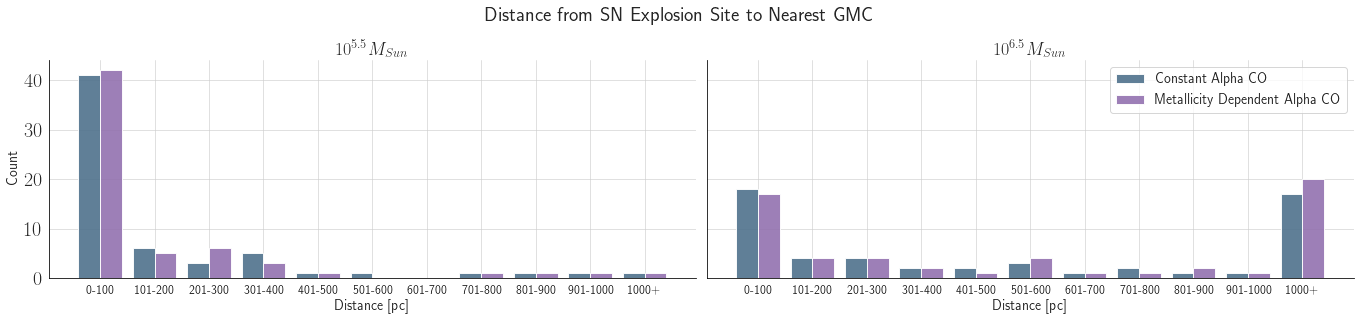

In [6]:
# Make histogram of nearest MC 10^5.5 & 6.5

#set up bins
#bins = [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000]
bins = [0,100,200,300,400,500,600,700,800,900,1000,1100]
ticks = [50,150,250,350,450,550,650,750,850,950,1050]
tickLabels = ["0-100", "101-200", "201-300", "301-400", "401-500", "501-600", "601-700", "701-800", "801-900", "901-1000", "1000+"]

sns.set_style("whitegrid", {'axes.linewidth': 1, 'axes.edgecolor':'black'})
sns.color_palette("dark")

f, ax = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = True, figsize = (19,4.5))

ax[0].set_xticks(ticks=ticks)
ax[1].set_xticks(ticks=ticks)
ax[0].set_xticklabels(["0-100", "101-200", "201-300", "301-400", "401-500", "501-600", "601-700", "701-800", "801-900", "901-1000", "1000+"],fontsize = 12)
ax[1].set_xticklabels(["0-100", "101-200", "201-300", "301-400", "401-500", "501-600", "601-700", "701-800", "801-900", "901-1000", "1000+"],fontsize = 12)
#ax[0].set_xticklabels(["0", "100", "200", "300", "400", "500", "600", "700", "800", "900", "1000"])
#ax[1].set_xticklabels(["0", "100", "200", "300", "400", "500", "600", "700", "800", "900", "1000"])
n1, bins, patches = ax[0].hist([Dist55_ca,Dist55_mda], color = [cashmere, wisteria],label = ["Constant Alpha CO","Metallicity Dependent Alpha CO"], bins=bins, width = 40, alpha = 0.9)
ax[1].hist([Dist65_ca,Dist65_mda], color = [cashmere, wisteria],label = ["Constant Alpha CO","Metallicity Dependent Alpha CO"], bins=bins, width = 40, alpha = 0.9)
ax[0].grid(True, alpha = 0.75)
ax[1].grid(True, alpha = 0.75)
ax[0].set_title(r'$10^{5.5} M_{Sun}$', fontsize = 18)
ax[1].set_title(r'$10^{6.5} M_{Sun}$', fontsize = 18)
f.suptitle("Distance from SN Explosion Site to Nearest GMC", fontsize = 20)
f.subplots_adjust(wspace = 0.1, top = 0.85)
ax[1].legend(loc = "upper right", fontsize = 14)
ax[0].set_ylabel("Count", fontsize = 14)
ax[0].set_xlabel("Distance [pc]", fontsize = 14)
ax[1].set_xlabel("Distance [pc]", fontsize = 14)
sns.despine(left = False)
plt.tight_layout()

#f.savefig("../Figures/NearestMCHist.png")
print(n1)

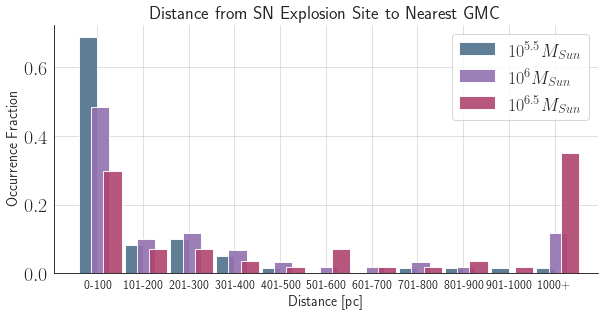

In [7]:
# Make histogram of nearest MC 10^5.5 & 6.5

#set up bins
#bins = [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000]
bins = [0,100,200,300,400,500,600,700,800,900,1000,1100]
ticks = [50,150,250,350,450,550,650,750,850,950,1050]
tickLabels = ["0-100", "101-200", "201-300", "301-400", "401-500", "501-600", "601-700", "701-800", "801-900", "901-1000", "1000+"]

sns.set_style("whitegrid", {'axes.linewidth': 1, 'axes.edgecolor':'black'})
sns.color_palette("dark")

f, ax = plt.subplots(nrows = 1, ncols = 1,figsize = (8.5,4.5))

weights55 = np.ones(len(Dist55_mda))/len(Dist55_mda)
weights6 = np.ones(len(Dist6_mda))/len(Dist6_mda)
weights65 = np.ones(len(Dist65_mda))/len(Dist65_mda)


ax.set_xticks(ticks=ticks)
ax.set_xticklabels(["0-100", "101-200", "201-300", "301-400", "401-500", "501-600", "601-700", "701-800", "801-900", "901-1000", "1000+"],fontsize = 12)
#ax.set_xticklabels(["0", "100", "200", "300", "400", "500", "600", "700", "800", "900", "1000"])
n1, bins, patches = ax.hist([Dist55_mda,Dist6_mda,Dist65_mda], weights = [weights55,weights6,weights65], color = [cashmere, wisteria, ruby],label = [r'$10^{5.5} M_{Sun}$',r'$10^{6} M_{Sun}$',r'$10^{6.5} M_{Sun}$'], bins=bins, width = 40, alpha = 0.9)
ax.grid(True, alpha = 0.75)
ax.set_title("Distance from SN Explosion Site to Nearest GMC", fontsize = 18)
ax.set_ylabel("Occurrence Fraction", fontsize = 14)
ax.set_xlabel("Distance [pc]", fontsize = 14)
plt.legend(loc="upper right", fontsize = 18)
sns.despine(left = False)
plt.tight_layout()

#f.savefig("../Figures/NearestMCHistMDA.png")

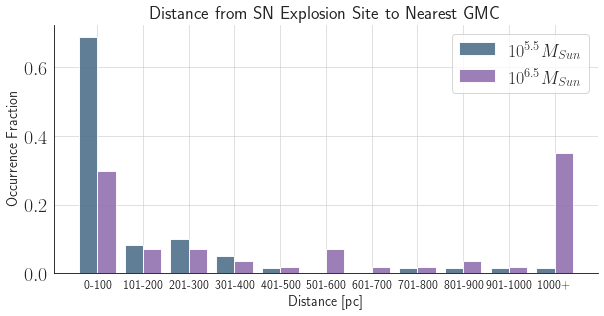

In [8]:
# Make histogram of nearest MC 10^5.5 & 6.5

sns.set_style("whitegrid", {'axes.linewidth': 1, 'axes.edgecolor':'black'})
sns.color_palette("dark")

f, ax = plt.subplots(nrows = 1, ncols = 1,figsize = (8.5,4.5))


ax.set_xticks(ticks=ticks)
ax.set_xticklabels(["0-100", "101-200", "201-300", "301-400", "401-500", "501-600", "601-700", "701-800", "801-900", "901-1000", "1000+"],fontsize = 12)
n1, bins, patches = ax.hist([Dist55_mda,Dist65_mda], weights = [weights55,weights65], color = [cashmere, wisteria],label = [r'$10^{5.5} M_{Sun}$',r'$10^{6.5} M_{Sun}$'], bins=bins, width = 40, alpha = 0.9)
ax.grid(True, alpha = 0.75)
ax.set_title("Distance from SN Explosion Site to Nearest GMC", fontsize = 18)
ax.set_ylabel("Occurrence Fraction", fontsize = 14)
ax.set_xlabel("Distance [pc]", fontsize = 14)
plt.legend(loc="upper right", fontsize = 18)
sns.despine(left = False)
plt.tight_layout()
f.savefig("../Figures/NearestMCHistMDA.png", dpi=300)

[[43.  8.  4.  3.  1.  0.  0.  0.  1.  0.  0.]
 [32.  8.  4.  2.  4.  2.  1.  3.  1.  1.  1.]]


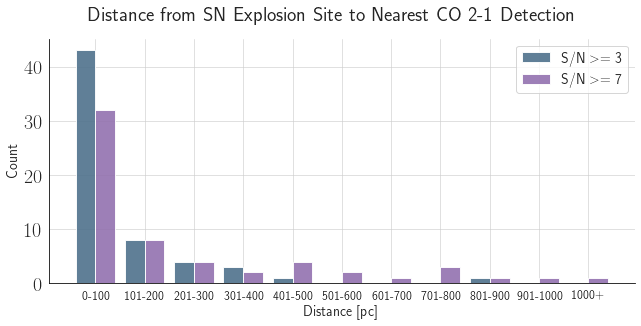

In [9]:
# Make histogram of nearest MC 10^5.5 & 6.5

#set up bins
#bins = [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000]
bins = [0,100,200,300,400,500,600,700,800,900,1000,1100]
ticks = [50,150,250,350,450,550,650,750,850,950,1050]
tickLabels = ["0-100", "101-200", "201-300", "301-400", "401-500", "501-600", "601-700", "701-800", "801-900", "901-1000", "1000+"]

sns.set_style("whitegrid", {'axes.linewidth': 1, 'axes.edgecolor':'black'})
sns.color_palette("dark")

f, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10.5,4.5))

ax.set_xticks(ticks=ticks)
ax.set_xticklabels(["0-100", "101-200", "201-300", "301-400", "401-500", "501-600", "601-700", "701-800", "801-900", "901-1000", "1000+"], fontsize = 12)
n,bins,patches = ax.hist([SNR_3_dist,SNR_7_dist], color = [cashmere, wisteria],label = [r"S/N $>=$ 3",r"S/N $>=$ 7"], bins=bins, width = 40, alpha = 0.9)
ax.grid(True, alpha = 0.75)
f.suptitle("Distance from SN Explosion Site to Nearest CO 2-1 Detection", fontsize = 20)
ax.legend(loc = "upper right", fontsize = 14)
ax.set_ylabel("Count", fontsize = 14)
ax.set_xlabel("Distance [pc]", fontsize = 14)

sns.despine(left = False)

f.savefig("../Figures/NearestMCHist_SNR.png")
print(n)

In [10]:
allData = Table.read('../Data/3.4.AllData.csv', format='csv')

allData

galaxy,SN_name,SN_type,SN_ra,SN_dec,SN_xCoord,SN_yCoord,SN_co21int,SN_co21err,SN_co21ew,map_beamsize,orient_ra,orient_dec,dist,orient_posang,orient_incl,size_r25,telOrient,ImageFile150,ErrFile150,AlphaCOFile,Names,MCSN55Int,MCSN55Intval,MCSN6Int,MCSN6Intval,MCSN65Int,MCSN65Intval,MCSN7Int,MCSN7Intval,MCSN75Int,MCSN75Intval,MCSN55Mass,MCSN55Massval,MCSN6Mass,MCSN6Massval,MCSN65Mass,MCSN65Massval,MCSN7Mass,MCSN7Massval,MCSN75Mass,MCSN75Massval,MCSN_SNR_7,MCSN_SNR_7_val,MCSN_SNR_9,MCSN_SNR_9_val,MCSN_SNR_1,MCSN_SNR_1_val,MCSN_SNR_3,MCSN_SNR_3_val,MCSN_SNR_5,MCSN_SNR_5_val
str8,str11,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,str112,str113,str74,str20,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ngc1566,ASASSN-14ha,II,65.0059,-54.9381,258.9038295074317,423.1062029210927,68.05383,1.8849889,12.188041,0.0003484111476313,65.00159,-54.93801,17.69,214.7,29.5,216.83093,12m+7m+tp,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1566/ngc1566_12m+7m+tp_co21_150pc_broad_mom0.fits,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1566/ngc1566_12m+7m+tp_co21_150pc_broad_emom0.fits,/data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/NGC1566_alphaCO21_Sun+20.fits,ngc1566_ASASSN-14ha_,7.168330791430105,61.926334381103516,7.168330791430105,61.926334381103516,7.168330791430105,61.926334381103516,7.168330791430105,61.926334381103516,577.5910393511059,189.28466796875,7.168330791430105,61.926334381103516,7.168330791430105,6794518.579826997,7.168330791430105,6794518.579826997,540.1480500825826,10247495.735757168,626.9203700447346,31862605.53927886,7.168330791430105,45.56260681152344,7.168330791430105,45.56260681152344,7.168330791430105,45.56260681152344,7.168330791430105,45.56260681152344,7.168330791430105,45.56260681152344
ngc4321,SN1901B,I,185.6971,15.8238,545.5920792633563,276.5735561756638,5.0824146,1.0344207,2.544713,0.000462934650464,185.72887,15.822304,15.21,156.2,38.5,182.86105,12m+7m+tp,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc4321/ngc4321_12m+7m+tp_co21_150pc_broad_mom0.fits,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc4321/ngc4321_12m+7m+tp_co21_150pc_broad_emom0.fits,/data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/NGC4321_alphaCO21_Sun+20.fits,ngc4321_SN1901B_,16.217608974124317,5.4790143966674805,32.95206950182446,6.2370805740356445,375.2361429425682,20.15619659423828,5429.02766974846,58.92905044555664,9348.094692036415,186.10044860839844,16.217608974124317,5.4790143966674805,16.217608974124317,1053493.1724780116,354.5195224142885,3342420.1186717595,5465.47290014249,10169412.927852659,9838.242679663315,32548988.676900666,32.95206950182446,7.592727184295654,74.35152882558509,9.115458488464355,16.217608974124317,6.640030384063721,16.217608974124317,6.640030384063721,16.217608974124317,6.640030384063721
ngc5236,SN1923A,II,204.2883,-29.8389,399.09014170428725,813.7841220160797,3.1662843,0.6370633,6.310522,0.000594044605435,204.2539,-29.865625,4.89,225.0,24.0,408.43347,12m+7m+tp,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc5236/ngc5236_12m+7m+tp_co21_150pc_broad_mom0.fits,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc5236/ngc5236_12m+7m+tp_co21_150pc_broad_emom0.fits,/data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/NGC5236_alphaCO21_Sun+20.fits,ngc5236_SN1923A_,4.97955838549907,2.6020655632019043,165.25801448750806,6.16483211517334,701.2762889030039,18.5152530670166,1327.7521680207906,60.38484573364258,3136.7306821082784,189.17770385742188,4.97955838549907,2.6020655632019043,165.25801448750806,1053035.375,701.2762889030039,3162651.75,1327.7521680207906,10314536.0,3136.7306821082784,32314072.0,4.97955838549907,9.050134658813477,4.97955838549907,9.050134658813477,4.97955838549907,9.050134658813477,4.97955838549

In [11]:
# Here is some rudimentary by type histogram plotting in case we decide to pursue this further.
import pandas as pd
data55 = pd.DataFrame({"type55": types55_mda,
                   "int55" : Dist55_mda})

data65 = pd.DataFrame({"type65": types65_mda,
                   "int65" : Dist65_mda})


<AxesSubplot:xlabel='int55', ylabel='Count'>

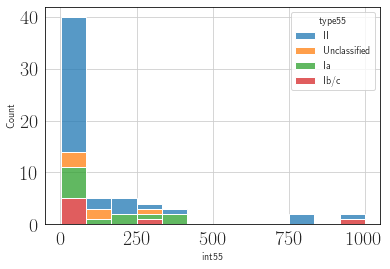

In [12]:
sns.histplot(data55, x="int55", hue="type55", multiple="stack")


<AxesSubplot:xlabel='int65', ylabel='Count'>

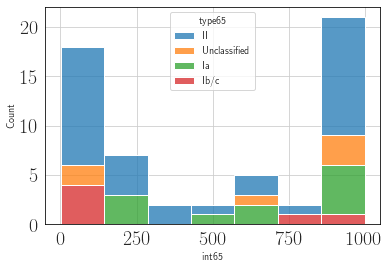

In [13]:
sns.histplot(data65, x="int65", hue="type65", multiple="stack")

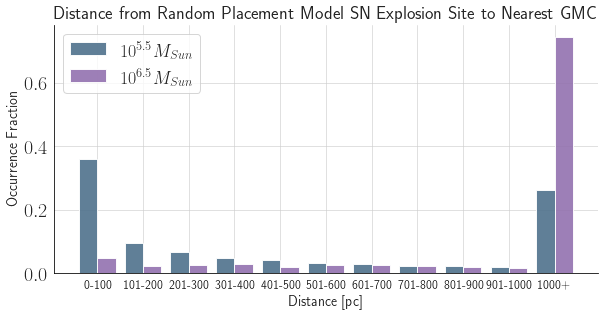

In [14]:
# Now make plots with model data

modWei55 = np.ones(len(mod1_55D))/len(mod1_55D)
modWei65 = np.ones(len(mod1_65D))/len(mod1_65D)


sns.set_style("whitegrid", {'axes.linewidth': 1, 'axes.edgecolor':'black'})
sns.color_palette("dark")

f, ax = plt.subplots(nrows = 1, ncols = 1,figsize = (8.5,4.5))

ax.set_xticks(ticks=ticks)
ax.set_xticklabels(["0-100", "101-200", "201-300", "301-400", "401-500", "501-600", "601-700", "701-800", "801-900", "901-1000", "1000+"],fontsize = 12)
#n1, bins, patches = ax.hist([Dist55_mda,Dist65_mda], weights = [weights55,weights65], color = [cashmere, wisteria],label = [r'$10^{5.5} M_{Sun}$',r'$10^{6.5} M_{Sun}$'], bins=bins, width = 40, alpha = 0.9)
n1, bins, patches = ax.hist([mod1_55D,mod1_65D], weights = [modWei55,modWei65], color = [cashmere, wisteria],label = [r'$10^{5.5} M_{Sun}$',r'$10^{6.5} M_{Sun}$'], bins=bins, width = 40, alpha = 0.9)
ax.grid(True, alpha = 0.75)
ax.set_title("Distance from Random Placement Model SN Explosion Site to Nearest GMC", fontsize = 18)
ax.set_ylabel("Occurrence Fraction", fontsize = 14)
ax.set_xlabel("Distance [pc]", fontsize = 14)
plt.legend(loc="upper left", fontsize = 18)
sns.despine(left = False)
plt.tight_layout()

f.savefig("../Figures/NearestMCHistModel1.png", dpi=300)



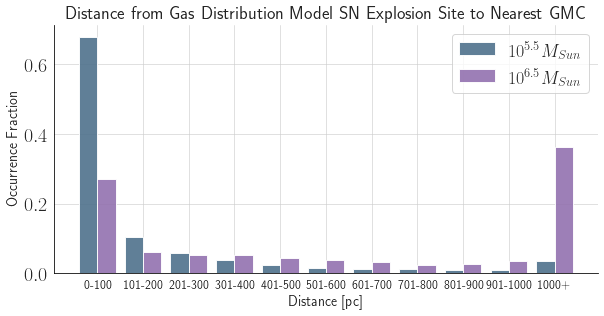

In [15]:
# Now make plots with model data

modWei55 = np.ones(len(mod2_55D))/len(mod2_55D)
modWei65 = np.ones(len(mod2_65D))/len(mod2_65D)


sns.set_style("whitegrid", {'axes.linewidth': 1, 'axes.edgecolor':'black'})
sns.color_palette("dark")

f, ax = plt.subplots(nrows = 1, ncols = 1,figsize = (8.5,4.5))

ax.set_xticks(ticks=ticks)
ax.set_xticklabels(["0-100", "101-200", "201-300", "301-400", "401-500", "501-600", "601-700", "701-800", "801-900", "901-1000", "1000+"],fontsize = 12)
#n1, bins, patches = ax.hist([Dist55_mda,Dist65_mda], weights = [weights55,weights65], color = [cashmere, wisteria],label = [r'$10^{5.5} M_{Sun}$',r'$10^{6.5} M_{Sun}$'], bins=bins, width = 40, alpha = 0.9)
n1, bins, patches = ax.hist([mod2_55D,mod2_65D], weights = [modWei55,modWei65], color = [cashmere, wisteria],label = [r'$10^{5.5} M_{Sun}$',r'$10^{6.5} M_{Sun}$'], bins=bins, width = 40, alpha = 0.9)
ax.grid(True, alpha = 0.75)
ax.set_title("Distance from Gas Distribution Model SN Explosion Site to Nearest GMC", fontsize = 18)
ax.set_ylabel("Occurrence Fraction", fontsize = 14)
ax.set_xlabel("Distance [pc]", fontsize = 14)
plt.legend(loc="upper right", fontsize = 18)
sns.despine(left = False)
plt.tight_layout()

f.savefig("../Figures/NearestMCHistModel2.png",dpi=300)